# Titanic starter examples: Logistic Regression, Optuna and SHAP
by Artyom Glazunov

Hello! I'm Artyom, and this is my series of notebooks "Titanic examples", where I show you different ML approaches and algorithms in action on the Titanic task. To remind you, in this task we need to predict the passenger's survival using some information, such as gender, age, class etc.

The previous tutorial is here:
https://www.kaggle.com/artemglazunov1990/titanic-starters-catboost-optuna-and-shap

In this notebook you can check out how to solve the task using the algorithm of Logistic Regression. 

Lets's describe our plan:
- EDA and feature engineering
- Baseline solution and QA
- Model selection
- Prediction and feature importance analysis
- Submission

### Let's load libs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import warnings
import copy

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
import category_encoders as ce

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer

from matplotlib import pyplot as plt
import seaborn as sns
import eli5

import optuna
import shap

### Load the data

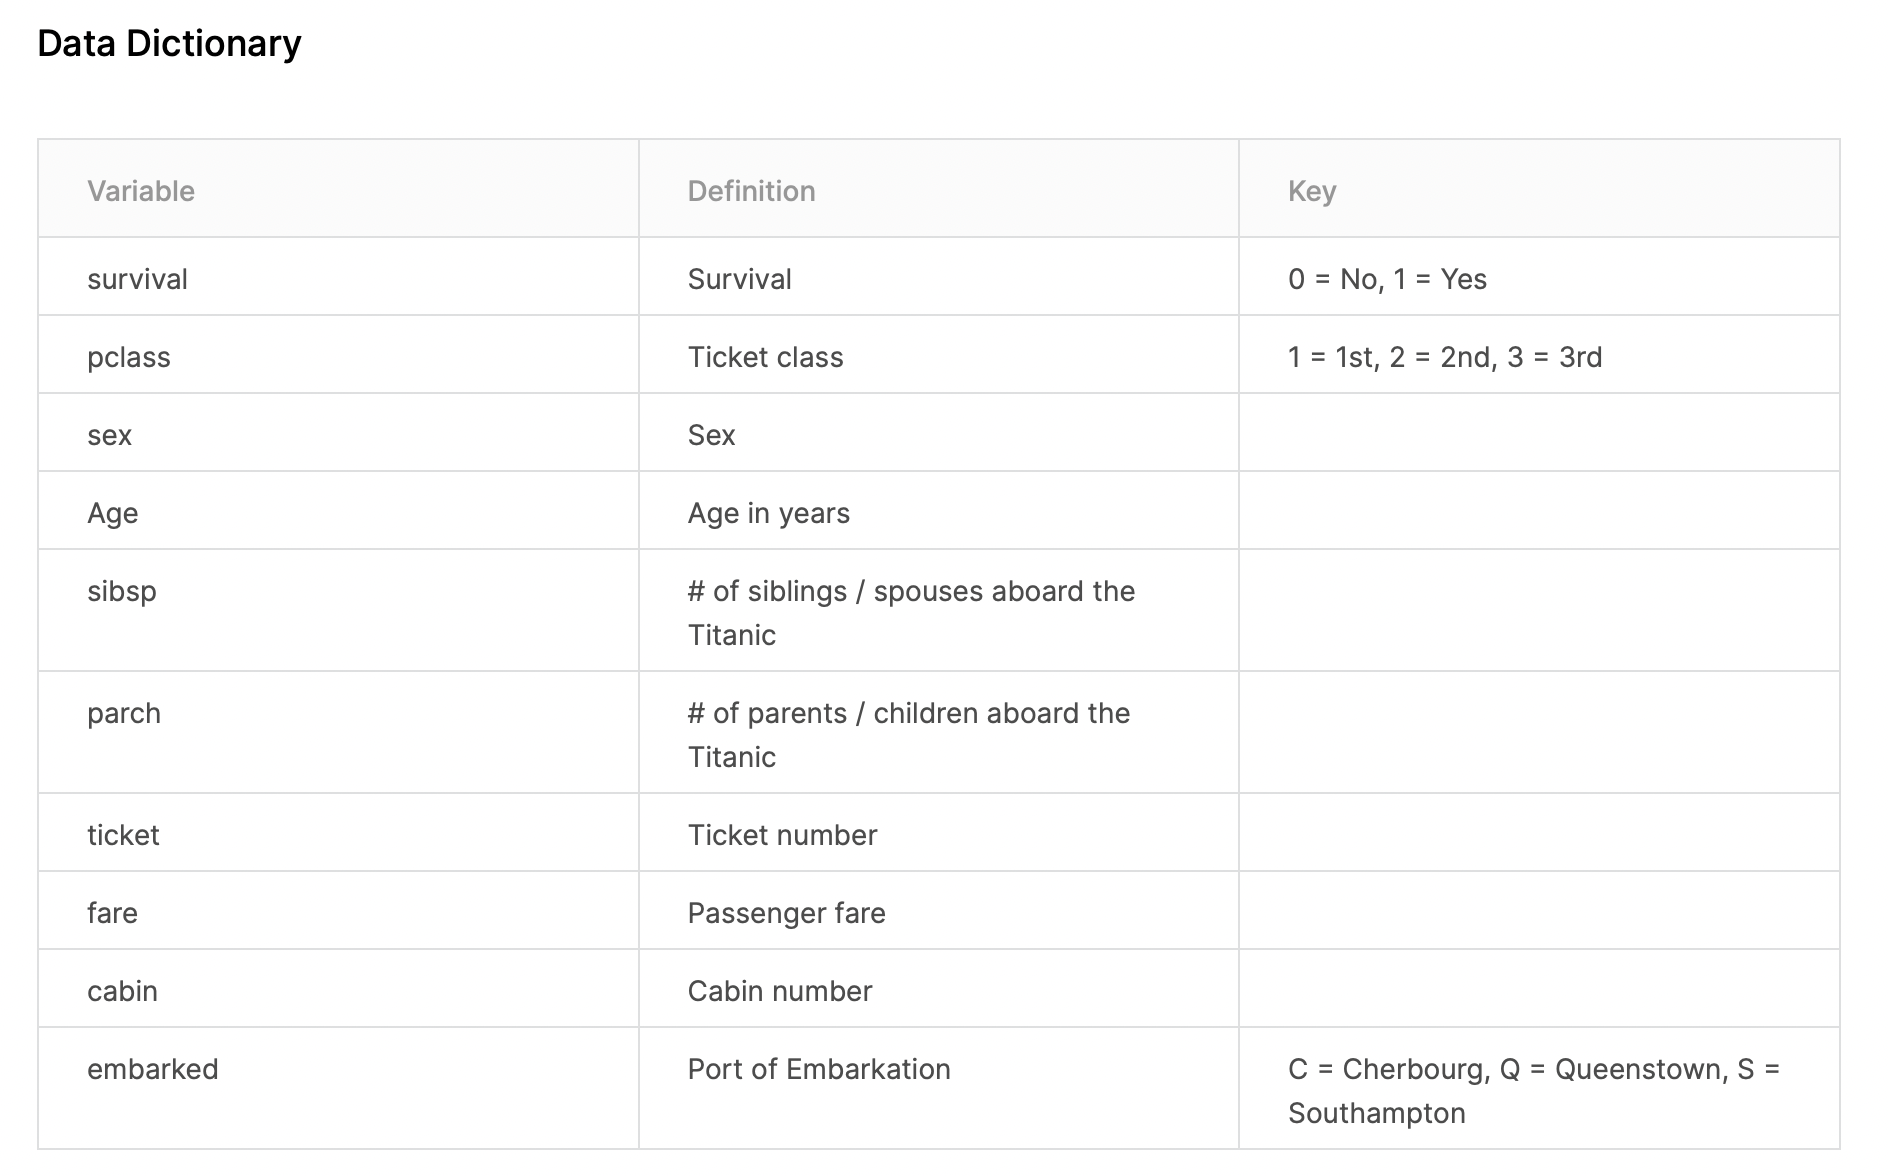

In [3]:
PATH_TO_DATA = '/kaggle/input/titanic'

In [4]:
train_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

### Look at null values in our dataset

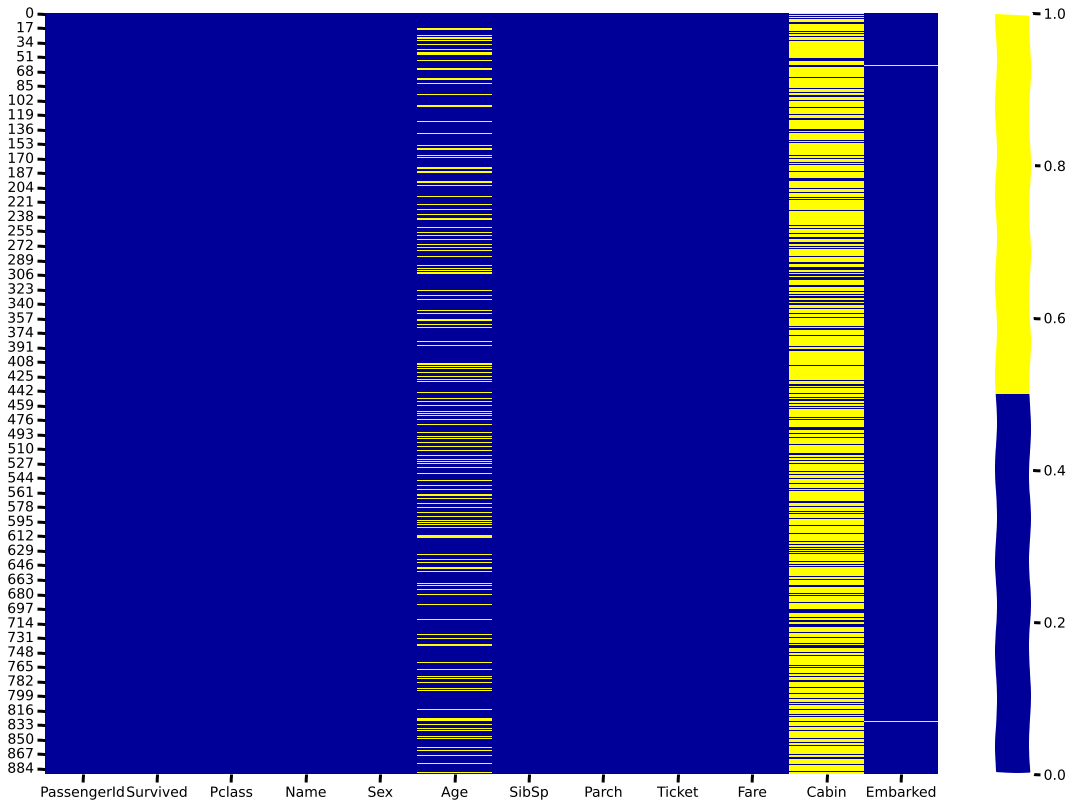

In [7]:
def null_map(data):
    #Show null map of the data
    
    data_to_heat = data.isnull()
    null_count = (data_to_heat == True).sum().sum()
    with plt.xkcd():
        plt.figure(figsize=(20,14))
        if null_count > 0:
            colors = ['#000099', '#ffff00'] 
        else:
            colors = ['#000099'] 
        sns.heatmap(data_to_heat,cmap = sns.color_palette(colors));
        
null_map(train_data)

In [8]:
(train_data[["Cabin"]].isnull() == True).sum().sum() / train_data.shape[0]

0.7710437710437711

In [9]:
(train_data[["Sex"]].isnull() == True).sum().sum() / train_data.shape[0]

0.0

### We can see that some features have many missed values, but we'll use all the features to preserve more information.

### Now, we're going to create some new features. First of all, let's look at all the possible values of the "Cabin" feature. Then we'll clean them up form unnecessary symbols and create new categorical feature. Having done that, we'll do the same work with the "Ticket" feature. 

In [10]:
train_data.Cabin.astype(str).unique()

array(['nan', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64

In [11]:
def remove_digits_and_other(x):
    #Clean up feature values from digits and other features
    
    return ''.join(i for i in str(x) if not i.isdigit() and i not in ["/", ".", " "])

remove_digits_and_other('B69')

'B'

In [12]:
train_data["Cabin_class"] = train_data["Cabin"].apply(remove_digits_and_other)
train_data["Ticket_kind"] = train_data["Ticket"].apply(remove_digits_and_other)

### Next, we'll create some new features using info about passengers.

In [13]:
def create_super_features(data_in, feature_names=["super_bin", "super_cat"], q20age=19, med=28, q80age=41):
    #Create additional features using default set
    
    data = data_in.copy()
    
    super_bin = []
    super_cat = []
    
    for ind in range(data.shape[0]):
        human = data.iloc[ind]
        if human["Age"] > med and human["Sex"] == "female" and human["Pclass"] in [1, 2]:
            super_bin.append(1)
        else:
            super_bin.append(0)
            
        if human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("young_poor_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("middle_poor_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 3:
            super_cat.append("old_poor_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("young_poor_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("middle_poor_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 3:
            super_cat.append("old_poor_female")
        
        elif human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("young_not_rich_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("middle_not_rich_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 2:
            super_cat.append("old_not_rich_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("young_not_rich_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("middle_not_rich_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 2:
            super_cat.append("old_not_rich_female")
        
        elif human["Age"] <= q20age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("young_rich_male")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("middle_rich_male")
        elif human["Age"] > q80age and human["Sex"] == "male" and human["Pclass"] == 1:
            super_cat.append("old_rich_male")
            
        elif human["Age"] <= q20age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("young_rich_female")
        elif human["Age"] > q20age  and human["Age"] <= q80age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("middle_rich_female")
        elif human["Age"] > q80age and human["Sex"] == "female" and human["Pclass"] == 1:
            super_cat.append("old_rich_female")
        
        else:
            super_cat.append("other")
    
    data["super_bin"] = super_bin
    data["super_cat"] = super_cat
    #Let's add interesting numeric features
    data['super_num_fa'] = data['Fare'].values * data["Age"].values
    data["super_num_fare_bin"] = data['Fare'].values * super_bin
    return data

In [14]:
train_data = create_super_features(train_data)

In [15]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_class,Ticket_kind,super_bin,super_cat,super_num_fa,super_num_fare_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,nan,A,0,middle_poor_male,159.5000,0.0000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,PC,1,middle_rich_female,2708.7654,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,nan,STONO,0,middle_poor_female,206.0500,0.0000
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,,1,middle_rich_female,1858.5000,53.1000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,nan,,0,middle_poor_male,281.7500,0.0000


### Let's visualize our data and look at their distributions

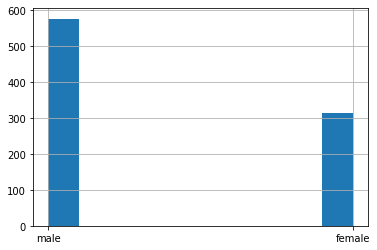

In [16]:
train_data["Sex"].hist();

### We have more "male" entries, but it won't be a problem, because "female" entries are also represented. Let's look at the remaining features.

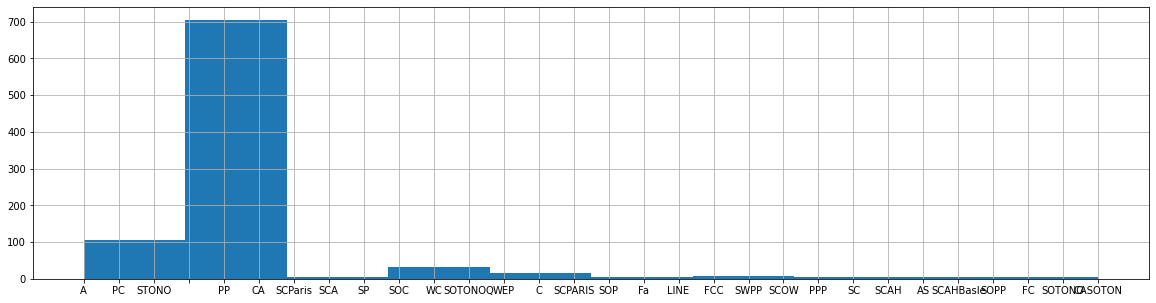

In [17]:
plt.figure(figsize=(20,5))
train_data["Ticket_kind"].hist();

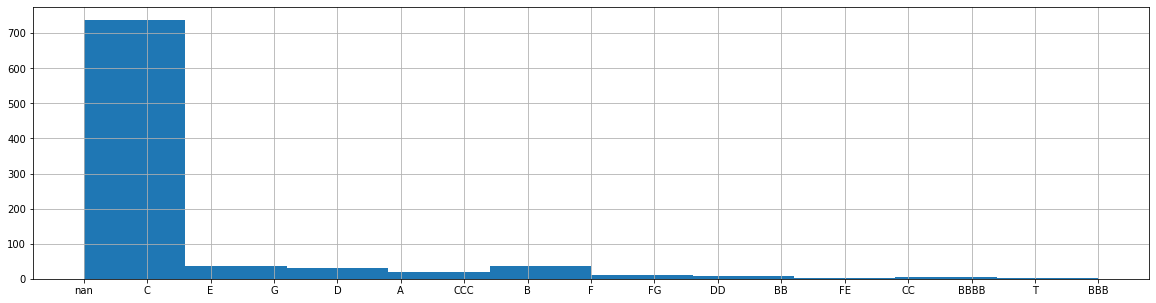

In [18]:
plt.figure(figsize=(20,5))
train_data.Cabin_class.hist();

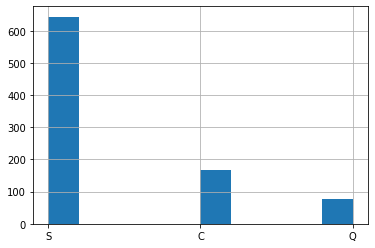

In [19]:
train_data.Embarked.hist();

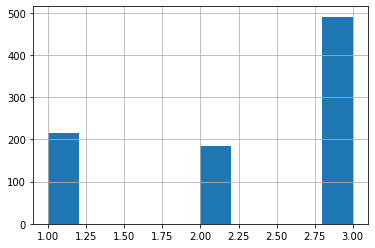

In [20]:
train_data.Pclass.hist();

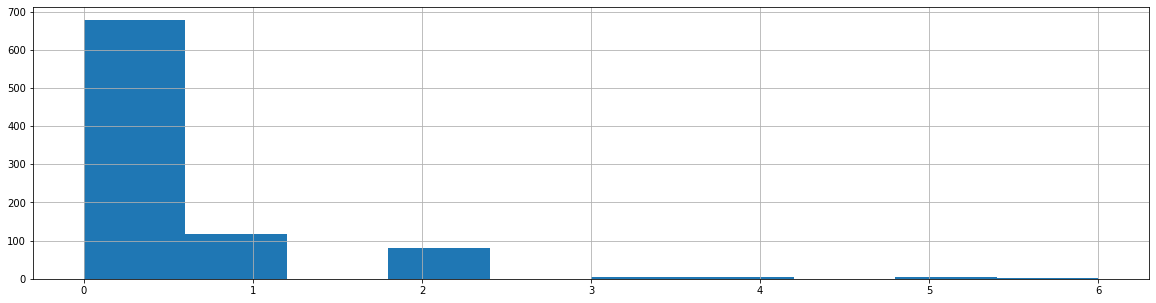

In [21]:
plt.figure(figsize=(20,5))
train_data.Parch.hist();

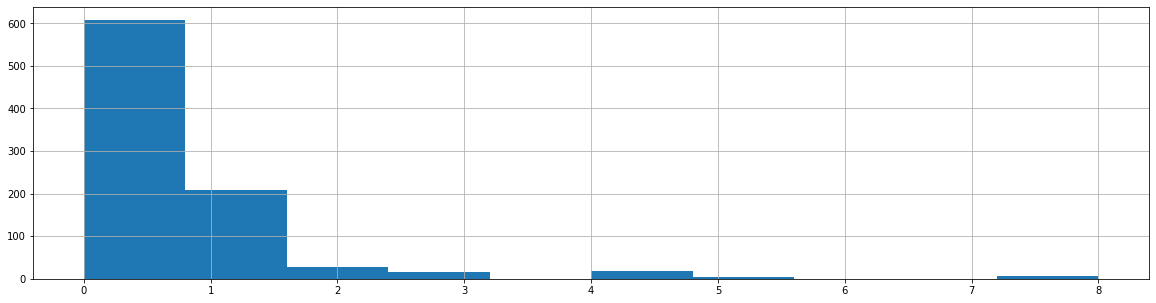

In [22]:
plt.figure(figsize=(20,5))
train_data.SibSp.hist();

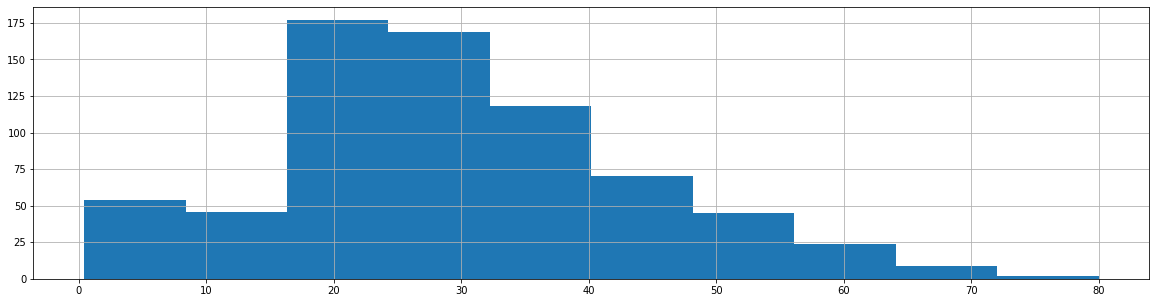

In [23]:
plt.figure(figsize=(20,5))
train_data.Age.hist();

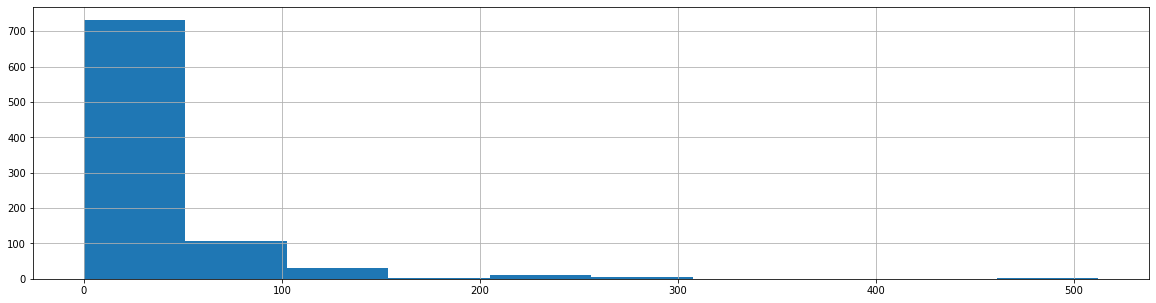

In [24]:
plt.figure(figsize=(20,5))
train_data.Fare.hist();

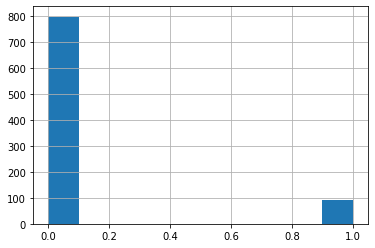

In [25]:
train_data.super_bin.hist();

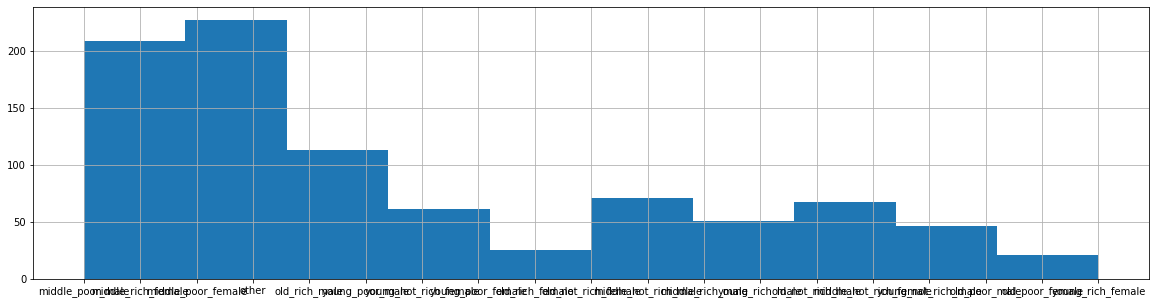

In [26]:
plt.figure(figsize=(20,5))
train_data.super_cat.hist();

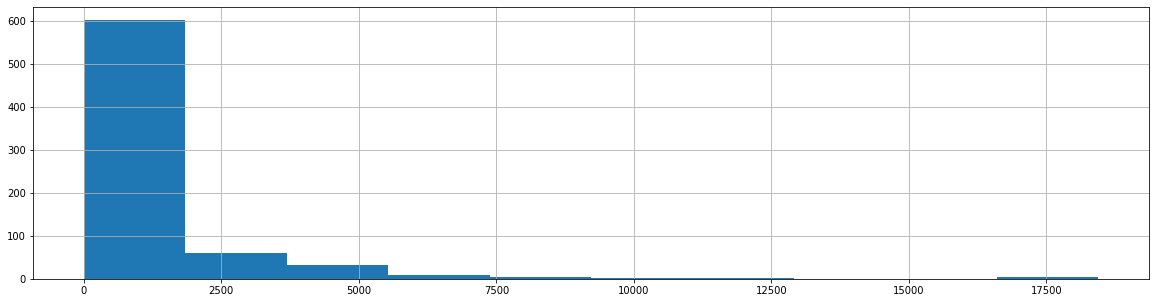

In [27]:
plt.figure(figsize=(20,5))
train_data.super_num_fa.hist();

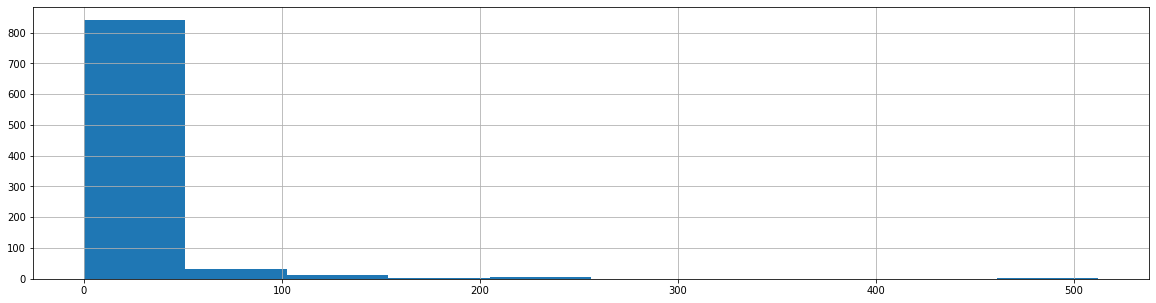

In [28]:
plt.figure(figsize=(20,5))
train_data.super_num_fare_bin.hist();

### We have some skewness in distributions. This may cause a problem for some cases, that's why we'll try different transformations later. But firstly, we'll check out how our linear model can deal without any preparations.

### Previously, let's prepare new features for the test data

In [29]:
test_data["Cabin_class"] = test_data["Cabin"].apply(remove_digits_and_other)
test_data["Ticket_kind"] = test_data["Ticket"].apply(remove_digits_and_other)
test_data = create_super_features(test_data)

### Baseline model (without preparations of distributions)

In [30]:
def to_categorical(X, cat_cols = []):
    #Categotical features to str format
    
    for col in cat_cols:
        X[col] = X[col].astype(str)
    return X

#Our features:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', "Cabin_class", "Ticket_kind", "super_cat"]
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]

In [31]:
warnings.filterwarnings('ignore')

X = to_categorical(train_data[numeric_cols + cat_cols], cat_cols)
y = train_data.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

encoder = ce.cat_boost.CatBoostEncoder(random_state=42, cols=cat_cols)
encoder.fit(X_train, y_train)
X_train_prep = encoder.transform(X_train).fillna(0)
X_val_prep = encoder.transform(X_val).fillna(0)

estimator = LogisticRegression(random_state=42, max_iter = 1000)
estimator.fit(X_train_prep, y_train)
probs = estimator.predict_proba(X_val_prep)[:, 1]

In [32]:
def accuracy_plot(y_true, probs, thrshs):
    #Visualize the relationship between accuracy and threshold value
    
    accuracy_scores=[]
    thrshs=thrshs
    for threshold in thrshs:
        y_pred = [1 if prob > threshold else 0 for prob in probs]
        accuracy_scores.append(accuracy_score(y_true, y_pred))
    
    plt.plot(thrshs, accuracy_scores, label='accuracy'); 
    plt.xlabel('threshold')
    plt.legend()
    plt.title('Relationship between accuracy and threshold value')
    plt.grid(True)
    plt.ylabel('accuracy');

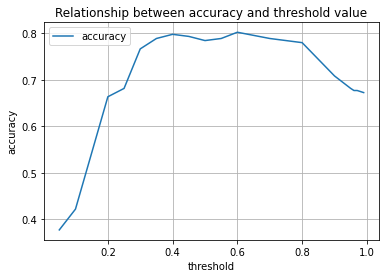

In [33]:
accuracy_plot(y_val, probs, 
              [0.05,0.1,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

### Not bad results. Now, we'll try to work on the distributions and make our features more normally distributed. Maybe, it can help improve the classification quality.

### But firstly, create some useful classes

In [34]:
class DataTransformer(TransformerMixin, BaseEstimator):
    """Transformer wrapper to work with Pandas DataFrames
    
    Class that wraps sklearn transformers (like PowerTransformer)
    and make it transform part of columns returning Pandas DataFrame
    """
    
    def __init__(self, transformer, columns):
        self.transformer = transformer #sklearn transformer
        self.columns = columns #columns to transform
    
    def fit(self, X, y=None):
        #Fit initial transformer on a part of the columns
        self.transformer.fit(X[self.columns])
        return self
    
    def transform(self, X):
        #Transform data and return Pandas DataFrame
        
        data_new = X.copy()
        names = self.columns
        transformed_columns = self.transformer.transform(data_new[names])
        transformed_cols_df = pd.DataFrame(transformed_columns, columns=names)
        for name in names:
            data_new[name] = transformed_cols_df[name].values
        return data_new


class MySimpleClfPipe(TransformerMixin, BaseEstimator):
    """Simple class to create clf pipeline
    
    encoder - categorical data encoder
    encoder_additional - the second encoder if needed
    imputer - fill na values
    normalizer - change numeric data distribution
    estimator - classifier
    """
    
    def __init__(self, encoder=None, encoder_additional=None, imputer=None, normalizer=None, estimator=None):
        self.encoder = encoder
        self.encoder_additional = encoder_additional
        self.imputer = imputer
        self.normalizer = normalizer
        self.estimator = estimator
        
    def fit(self, X, y):
        # fit all the transformers and estimator
        
        data = X.copy()
        if self.encoder:
            self.encoder.fit(data, y)
            data = self.encoder.transform(data)
        if self.encoder_additional:
            self.encoder_additional.fit(data, y)
            data = self.encoder_additional.transform(data)    
        if self.imputer:
            self.imputer.fit(data)
            data = self.imputer.transform(data)
        if self.normalizer:
            self.normalizer.fit(data)
            data = self.normalizer.transform(data)
        self.estimator.fit(data, y)
        return self
    
    def transform(self, X):
        # apply transformers on the data 
        
        data = X.copy()
        if self.encoder:
            data = self.encoder.transform(data)
        if self.encoder_additional:
            data = self.encoder_additional.transform(data)
        if self.imputer:
            data = self.imputer.transform(data)
        if self.normalizer:
            data = self.normalizer.transform(data)
        return data
    
    def predict(self, X):
        #transform the data and predict labels
        
        data = self.transform(X)
        predictions = self.estimator.predict(data)
        return predictions
    
    def predict_proba(self, X):
        #transform the data and predict probs for classes
        
        data = self.transform(X)
        probs = self.estimator.predict_proba(data)
        return probs

### Before normalization, let's only scale our data (numeric columns (except "super_bin" feature) and all categorical feature after encoder)

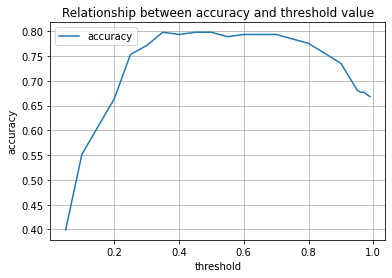

In [35]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', "Cabin_class", "Ticket_kind", "super_cat"]
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_scale = [col for col in (cat_cols + numeric_cols) if col != "super_bin"]

X = to_categorical(train_data[numeric_cols + cat_cols], cat_cols)
y = train_data.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

stages = {"encoder": ce.cat_boost.CatBoostEncoder(random_state=42, cols=cat_cols),
          "imputer": DataTransformer(SimpleImputer(strategy="constant", 
                                                   fill_value=0), 
                                     ["Age", "super_num_fa"]),
          "normalizer": DataTransformer(StandardScaler(), cols_to_scale),
          "estimator": LogisticRegression(random_state=42)
         }
pipe = MySimpleClfPipe(**stages)
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_val)[:, 1]
accuracy_plot(y_val, probs, 
              [0.05,0.1,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

### Slightly better results. Let's try Yeo-Johnson transformation 
(https://en.wikipedia.org/wiki/Power_transform#Yeo–Johnson_transformation)

### Let's scale and normalize numeric columns (except "super_bin" feature) and all categorical feature after encoder.

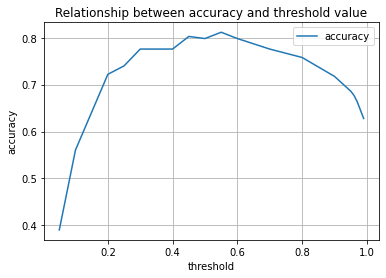

In [36]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', "Cabin_class", "Ticket_kind", "super_cat"]
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = [col for col in (cat_cols + numeric_cols) if col != "super_bin"]

X = to_categorical(train_data[numeric_cols + cat_cols], cat_cols)
y = train_data.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

stages = {"encoder": ce.cat_boost.CatBoostEncoder(random_state=42, cols=cat_cols),
          "imputer": DataTransformer(SimpleImputer(strategy="constant", 
                                                   fill_value=0), 
                                     ["Age", "super_num_fa"]),
          "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
          "estimator": LogisticRegression(random_state=42)
         }
pipe = MySimpleClfPipe(**stages)
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_val)[:, 1]
accuracy_plot(y_val, probs, 
              [0.05,0.1,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

### Although the distributions yet differ from the Normal distribution, our transformation  gives us slightly better quality for medium thresholds. But in this task such preprocessing didn't help much.

### Let's try to change categorical encoder to one-hot

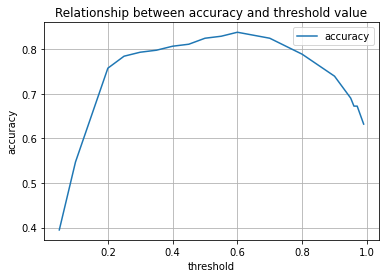

In [37]:
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', "Cabin_class", "Ticket_kind", "super_cat"]
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]

stages = {"encoder": ce.one_hot.OneHotEncoder(cols=cat_cols),
          "imputer": DataTransformer(SimpleImputer(), ["Age", "super_num_fa"]),
          "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
          "estimator": LogisticRegression(random_state=42, max_iter=1000)
         }
pipe = MySimpleClfPipe(**stages)
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_val)[:, 1]
accuracy_plot(y_val, probs, 
              [0.05,0.1,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

### Better quality. Let's try to use ordinal encoder (for Parch and SibSp) and one-hot (for others) 

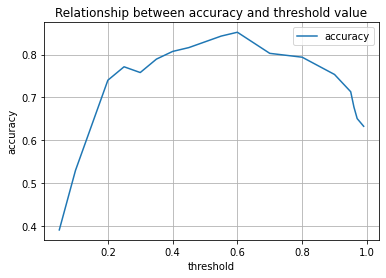

In [38]:
cat_cols_ohe = ['Sex', 'Embarked', 'Pclass', "Cabin_class", "Ticket_kind", "super_cat"]
cat_cols_ord = ['Parch', 'SibSp']
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]

X = to_categorical(train_data[numeric_cols + cat_cols_ohe + cat_cols_ord], cat_cols_ohe + cat_cols_ord)
y = train_data.Survived
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

stages = {"encoder": ce.one_hot.OneHotEncoder(cols=cat_cols_ohe),
          "encoder_additional": ce.ordinal.OrdinalEncoder(cols=cat_cols_ord),
          "imputer": DataTransformer(SimpleImputer(), ["Age", "super_num_fa"]),
          "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
          "estimator": LogisticRegression(random_state=42)
         }
pipe = MySimpleClfPipe(**stages)
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_val)[:, 1]
accuracy_plot(y_val, probs, 
              [0.05,0.1,0.2,0.25,0.3,0.35,0.4, 0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.99])

### Again, better quality, not bad!

### Now, we're going to optimize the hyperparameters using optuna
Here we don't use all the important parameters and our optimization lasts only 20 trials. 
For more info see the docs: 
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://optuna.org

In [39]:
warnings.filterwarnings('ignore')

cat_cols_ohe = ['Sex', 'Embarked', 'Pclass', "Cabin_class", "Ticket_kind", "super_cat"]
cat_cols_ord = ['Parch', 'SibSp']
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]

cv_stds = []
def objective(trial):
    
    stages = {"encoder": ce.one_hot.OneHotEncoder(cols=cat_cols_ohe),
              "encoder_additional": ce.ordinal.OrdinalEncoder(cols=cat_cols_ord),
              "imputer": DataTransformer(SimpleImputer(), ["Age", "super_num_fa"]),
              "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
              "estimator": LogisticRegression(random_state=42, max_iter=1000)
             }
    pipe = MySimpleClfPipe(**stages)
    
    param = {
        "imputer__transformer__strategy": trial.suggest_categorical(
            "imputer__transformer__strategy", ["mean", "median", "constant"],
        ),
        "estimator__class_weight": trial.suggest_categorical(
            "estimator__class_weight", [None, "balanced"],
        ),
        "estimator__penalty": trial.suggest_categorical(
            "estimator__penalty", ["l1", "l2", "elasticnet"],
        ),
        "estimator__C": trial.suggest_loguniform("estimator__C", 1e-2, 1e2),
    }
    
    if param["estimator__penalty"] != "l2":
        param["estimator__solver"] = "saga"
    if param["estimator__penalty"] == "elasticnet":
        param["estimator__l1_ratio"] = trial.suggest_float("estimator__l1_ratio", 0, 1)
    
    pipe.set_params(**param)
    
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    cv_results = cross_val_score(estimator=pipe,
                               X=X, y=y,
                               cv=cv,
                               scoring=make_scorer(accuracy_score))
    cv_stds.append(np.std(cv_results, ddof=1))#we will also try to find the solution with smaller std
    return np.mean(cv_results)

study = optuna.create_study(direction="maximize", study_name="my_optuna_optimization")
study.optimize(objective, n_trials=20)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-12 22:06:38,643] A new study created in memory with name: my_optuna_optimization
[I 2022-02-12 22:06:42,611] Trial 0 finished with value: 0.8047054902436068 and parameters: {'imputer__transformer__strategy': 'median', 'estimator__class_weight': None, 'estimator__penalty': 'l1', 'estimator__C': 17.075343488935022}. Best is trial 0 with value: 0.8047054902436068.
[I 2022-02-12 22:06:45,216] Trial 1 finished with value: 0.8047206399224337 and parameters: {'imputer__transformer__strategy': 'median', 'estimator__class_weight': None, 'estimator__penalty': 'elasticnet', 'estimator__C': 4.444703793267358, 'estimator__l1_ratio': 0.4588163619425488}. Best is trial 1 with value: 0.8047206399224337.
[I 2022-02-12 22:06:49,046] Trial 2 finished with value: 0.8024633377772391 and parameters: {'imputer__transformer__strategy': 'median', 'estimator__class_weight': None, 'estimator__penalty': 'l1', 'estimator__C': 6.50825097449483}. Best is trial 1 with value: 0.8047206399224337.
[I 2022-02-

Number of finished trials: 20
Best trial:
  Value: 0.8159516018260413
  Params: 
    imputer__transformer__strategy: mean
    estimator__class_weight: None
    estimator__penalty: elasticnet
    estimator__C: 0.31209319698020294
    estimator__l1_ratio: 0.28866230523923386


In [40]:
params = trial.params
if trial.params["estimator__penalty"] != "l2":
        params["estimator__solver"] = "saga"
params

{'imputer__transformer__strategy': 'mean',
 'estimator__class_weight': None,
 'estimator__penalty': 'elasticnet',
 'estimator__C': 0.31209319698020294,
 'estimator__l1_ratio': 0.28866230523923386,
 'estimator__solver': 'saga'}

In [41]:
cv_stds[trial._number], np.mean(cv_stds)

(0.013941056075619357, 0.02354780414500846)

In [42]:
cat_cols_ohe = ['Sex', 'Embarked', 'Pclass', "Cabin_class", "Ticket_kind", "super_cat"]
cat_cols_ord = ['Parch', 'SibSp']
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]

stages = {"encoder": ce.one_hot.OneHotEncoder(cols=cat_cols_ohe),
          "encoder_additional": ce.ordinal.OrdinalEncoder(cols=cat_cols_ord),
          "imputer": DataTransformer(SimpleImputer(), ["Age", "super_num_fa"]),
          "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
          "estimator": LogisticRegression(random_state=42)
         }
pipe = MySimpleClfPipe(**stages)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
cv_results = cross_val_score(estimator=pipe,
                           X=X, y=y,
                           cv=cv,
                           scoring=make_scorer(accuracy_score))
np.mean(cv_results), np.std(cv_results, ddof=1)

(0.8137144992526159, 0.029464856110345973)

### We can compare default params results with optimized.

### Let's use optimized params to fit our final model. We'll use several models with different seeds for stability. We'll also fill na in columns with Fare, because there are some missed values in the test.

In [43]:
cat_cols_ohe = ['Sex', 'Embarked', 'Pclass', "Cabin_class", "Ticket_kind", "super_cat"]
cat_cols_ord = ['Parch', 'SibSp']
numeric_cols = ['Age', 'Fare', "super_bin", "super_num_fa", "super_num_fare_bin"]
cols_to_normalize = ['Age', 'Fare', "super_num_fa", "super_num_fare_bin"]

estimators = []
for seed in range(10):
    stages = {"encoder": ce.one_hot.OneHotEncoder(cols=cat_cols_ohe),
              "encoder_additional": ce.ordinal.OrdinalEncoder(cols=cat_cols_ord),
              "imputer": DataTransformer(SimpleImputer(), ["Age", "super_num_fa", "Fare", "super_num_fare_bin"]),
              "normalizer": DataTransformer(PowerTransformer(), cols_to_normalize),
              "estimator": LogisticRegression(random_state=42, max_iter=1000)
             }
    pipe = MySimpleClfPipe(**stages)
    pipe.set_params(**params)
    pipe.fit(X, y)
    estimators.append(copy.deepcopy(pipe))

### Final predictions

In [44]:
all_probs_test = []
for estimator in estimators:
    probs = estimator.predict_proba(to_categorical(test_data[numeric_cols + cat_cols_ohe + cat_cols_ord], 
                                                   cat_cols_ohe + cat_cols_ord))[:, 1]
    all_probs_test.append(probs.reshape((-1, 1)))
final_probs = np.hstack(all_probs_test).mean(axis=1)
final_probs.shape

(418,)

In [45]:
def write_to_submission_file(data_test, predicted_vals, out_file,
                             target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    
    predicted_df = pd.DataFrame(predicted_vals,
                                index = data_test[index_label],
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

threshold = 0.6
write_to_submission_file(test_data, 
                         [1 if prob > threshold else 0 for prob in final_probs], 
                         "submission_lr_opt_fin.csv")

### Let's look at feature importances pictures. For that purpose we'll use SHAP values

See also 
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html
- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html#
- https://www.youtube.com/watch?v=VB9uV-x0gtg

In [46]:
shap.initjs()

### Firstly, we'll try the easiest way and look at feature importance for the preprocessed features. To understand such features we need to work with our encoder mappings.

In [47]:
estimator.encoder

OneHotEncoder(cols=['Sex', 'Embarked', 'Pclass', 'Cabin_class', 'Ticket_kind',
                    'super_cat'])

### For example, let's consider "Sex" variable and look at the link beetween the original and preprocessed features.

In [48]:
gender_ord_mapping = estimator.encoder.ordinal_encoder.mapping[0]['mapping']
mapping_gender_df = estimator.encoder.mapping[0]['mapping'].loc[gender_ord_mapping]
mapping_gender_df.index = gender_ord_mapping.index
mapping_gender_df

,Sex_1,Sex_2
male,1,0
female,0,1
NaN,0,0


### Plot the feature importance picture

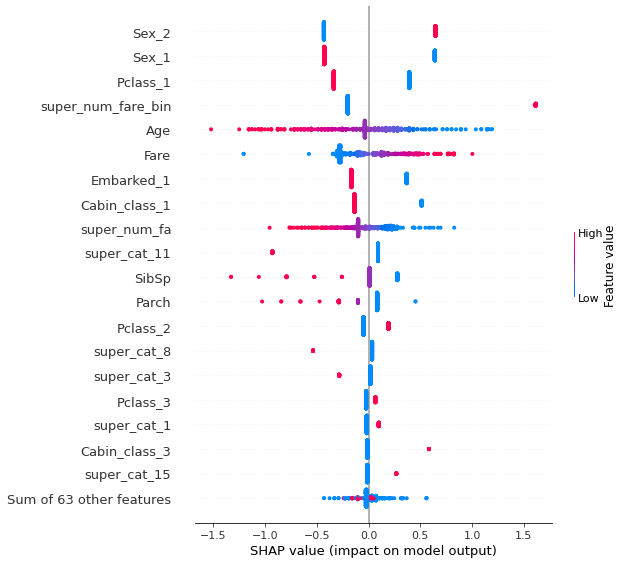

In [49]:
data_transf_train = estimator.transform(X)
data_transf_test = estimator.transform(to_categorical(test_data[numeric_cols + cat_cols_ohe + cat_cols_ord], 
                                                   cat_cols_ohe + cat_cols_ord))

explainer = shap.Explainer(estimator.estimator, 
                           data_transf_train, feature_names=data_transf_train.columns,
                          )

shap_values = explainer(data_transf_test)
shap.plots.beeswarm(shap_values, max_display=20)

### Look at one example...

In [50]:
shap.force_plot(shap_values[1])

### ... And many examples 

In [51]:
shap.plots.force(shap_values)

### But analyzing the features after preprocessing isn't very convenient way. Let's try another method - kernel explainer that allows us to consider the original features. For higher performance, we'll use only 30 objects from our test set and 100 samples during explanation. It'll affect quality.

In [52]:
def pipe_func(x):
    # Wrapper to preserve pandas df form for data and columns names
    
    data = pd.DataFrame(x, columns=numeric_cols + cat_cols_ohe + cat_cols_ord)
    probs = estimator.predict_proba(data)    
    return probs[:, 1]

train_data_orig = to_categorical(train_data[numeric_cols + cat_cols_ohe + cat_cols_ord], 
                                                   cat_cols_ohe + cat_cols_ord)
test_data_orig_sample = to_categorical(test_data[numeric_cols + cat_cols_ohe + cat_cols_ord], 
                                                   cat_cols_ohe + cat_cols_ord).iloc[:30]

explainer = shap.KernelExplainer(pipe_func, data=train_data_orig, link='logit')

shap_values = explainer.shap_values(test_data_orig_sample, nsamples=100)

  0%|          | 0/30 [00:00<?, ?it/s]

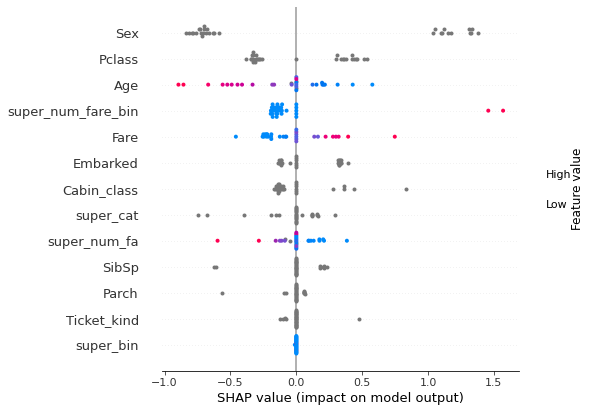

In [53]:
shap.summary_plot(shap_values, features=test_data_orig_sample, feature_names=X.columns)

In [54]:
shap.force_plot(explainer.expected_value, shap_values[1], test_data_orig_sample.iloc[1])

In [55]:
shap.force_plot(explainer.expected_value, shap_values, test_data_orig_sample)

### There is another way to show feature importance, we can plot coefficients

In [56]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values based on
    # https://habr.com/ru/company/ods/blog/323890/#6-plyusy-i-minusy-lineynyh-modeley-v-zadachah-mashinnogo-obucheniya
    
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


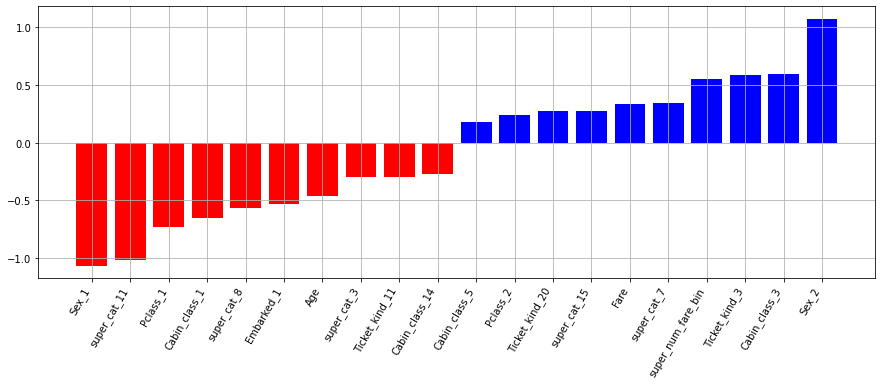

In [57]:
visualize_coefficients(estimator.estimator, list(data_transf_test.columns), 10)
plt.grid(True)

### And another way...

In [58]:
eli5.show_weights(estimator.estimator, 
                  feature_names=list(data_transf_test.columns), 
                  top=20)

### We can see that gender, age, class and their combinations were, probably, the most important parameters for the survival.

### Stay tuned! 